### Import Required Libraries

In [13]:
# common libraries
import pandas as pd # data manipulation and extraction
import numpy as np # numerical computation
import matplotlib.pyplot as plt # data visualization
import seaborn as sns # data visualization
import warnings # ignore warnings

# preprocessing libraries
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, LabelEncoder,label_binarize
from fast_ml.model_development import train_valid_test_split

# classifcation model and model selection libraries
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, StratifiedShuffleSplit 

# model evaluation libraries
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score, roc_auc_score, roc_curve, ConfusionMatrixDisplay
from itertools import cycle
from scipy import interp

# model inspection libraries
import shap
shap.initjs()

# UI settings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

### Read in the data

In [14]:
data = pd.read_csv('../notebooks/data/merged_inputed_data.csv')

print(f'Shape of dataframe: {data.shape}')
print('\n')

data.head()

Shape of dataframe: (1305, 368)




,meds_methadone_0,meds_buprenorphine_0,meds_methadone_1,meds_buprenorphine_1,meds_methadone_2,meds_buprenorphine_2,meds_methadone_3,meds_buprenorphine_3,meds_methadone_4,meds_buprenorphine_4,meds_methadone_5,meds_buprenorphine_5,meds_methadone_6,meds_buprenorphine_6,meds_methadone_7,meds_buprenorphine_7,meds_methadone_8,meds_buprenorphine_8,meds_methadone_9,meds_buprenorphine_9,meds_methadone_10,meds_buprenorphine_10,meds_methadone_11,meds_buprenorphine_11,meds_methadone_12,meds_buprenorphine_12,meds_methadone_13,meds_buprenorphine_13,meds_methadone_14,meds_buprenorphine_14,meds_methadone_15,meds_buprenorphine_15,meds_methadone_16,meds_buprenorphine_16,meds_methadone_17,meds_buprenorphine_17,meds_methadone_18,meds_buprenorphine_18,meds_methadone_19,meds_buprenorphine_19,meds_methadone_20,meds_buprenorphine_20,meds_methadone_21,meds_buprenorphine_21,meds_methadone_22,meds_buprenorphine_22,meds_methadone_23,meds_buprenorphine_23,meds_methadone_24,meds_buprenorphine_24,test_Propoxyphene_0,test_Amphetamines_0,test_alcohol_0,test_Cannabinoids_0,test_Benzodiazepines_0,test_Methadone_0,test_Oxycodone_0,test_Cocaine_0,test_Methamphetamine_0,test_Opiate300_0,test_Propoxyphene_1,test_Amphetamines_1,test_alcohol_1,test_Cannabinoids_1,test_Benzodiazepines_1,test_Methadone_1,test_Oxycodone_1,test_Cocaine_1,test_Methamphetamine_1,test_Opiate300_1,test_Propoxyphene_2,test_Amphetamines_2,test_alcohol_2,test_Cannabinoids_2,test_Benzodiazepines_2,test_Methadone_2,test_Oxycodone_2,test_Cocaine_2,test_Methamphetamine_2,test_Opiate300_2,test_Propoxyphene_3,test_Amphetamines_3,test_alcohol_3,test_Cannabinoids_3,test_Benzodiazepines_3,test_Methadone_3,test_Oxycodone_3,test_Cocaine_3,test_Methamphetamine_3,test_Opiate300_3,test_Propoxyphene_4,test_Amphetamines_4,test_alcohol_4,test_Cannabinoids_4,test_Benzodiazepines_4,test_Methadone_4,test_Oxycodone_4,test_Cocaine_4,test_Methamphetamine_4,test_Opiate300_4,test_Propoxyphene_5,test_Amphetamines_5,test_alcohol_5,test_Cannabinoids_5,test_Benzodiazepines_5,test_Methadone_5,test_Oxycodone_5,test_Cocaine_5,test_Methamphetamine_5,test_Opiate300_5,test_Propoxyphene_6,test_Amphetamines_6,test_alcohol_6,test_Cannabinoids_6,test_Benzodiazepines_6,test_Methadone_6,test_Oxycodone_6,test_Cocaine_6,test_Methamphetamine_6,test_Opiate300_6,test_Propoxyphene_7,test_Amphetamines_7,test_alcohol_7,test_Cannabinoids_7,test_Benzodiazepines_7,test_Methadone_7,test_Oxycodone_7,test_Cocaine_7,test_Methamphetamine_7,test_Opiate300_7,test_Propoxyphene_8,test_Amphetamines_8,test_alcohol_8,test_Cannabinoids_8,test_Benzodiazepines_8,test_Methadone_8,test_Oxycodone_8,test_Cocaine_8,test_Methamphetamine_8,test_Opiate300_8,test_Propoxyphene_9,test_Amphetamines_9,test_alcohol_9,test_Cannabinoids_9,test_Benzodiazepines_9,test_Methadone_9,test_Oxycodone_9,test_Cocaine_9,test_Methamphetamine_9,test_Opiate300_9,test_Propoxyphene_10,test_Amphetamines_10,test_alcohol_10,test_Cannabinoids_10,test_Benzodiazepines_10,test_Methadone_10,test_Oxycodone_10,test_Cocaine_10,test_Methamphetamine_10,test_Opiate300_10,test_Propoxyphene_11,test_Amphetamines_11,test_alcohol_11,test_Cannabinoids_11,test_Benzodiazepines_11,test_Methadone_11,test_Oxycodone_11,test_Cocaine_11,test_Methamphetamine_11,test_Opiate300_11,test_Propoxyphene_12,test_Amphetamines_12,test_alcohol_12,test_Cannabinoids_12,test_Benzodiazepines_12,test_Methadone_12,test_Oxycodone_12,test_Cocaine_12,test_Methamphetamine_12,test_Opiate300_12,test_Propoxyphene_13,test_Amphetamines_13,test_alcohol_13,test_Cannabinoids_13,test_Benzodiazepines_13,test_Methadone_13,test_Oxycodone_13,test_Cocaine_13,test_Methamphetamine_13,test_Opiate300_13,test_Propoxyphene_14,test_Amphetamines_14,test_alcohol_14,test_Cannabinoids_14,test_Benzodiazepines_14,test_Methadone_14,test_Oxycodone_14,test_Cocaine_14,test_Methamphetamine_14,test_Opiate300_14,test_Propoxyphene_15,test_Amphetamines_15,test_alcohol_15,test_Cannabinoids_15,test_Benzodiazepines_15,test_Methadone_15,test_Oxycodone_15,test_Cocaine_15,test_Meth

## Test outcome features for correlation

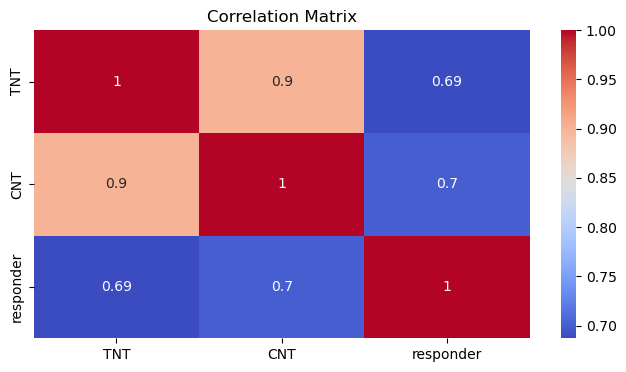

In [15]:
# show correlation matrix between 'TNT', 'CNT' and 'responder' columns
corr = data[['TNT','CNT','responder']].corr()
corr.style.background_gradient(cmap='coolwarm')

# plot correlation matrix
plt.figure(figsize=(8,4))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()


## Remove Features to prevent data leakage
The opiate tests and self reported use for the final month of treatment are removed to prevent data leakage

In [16]:
# define parameters

# remove the final 4 weeks of opiate tests, as they are included in the responder column
# also remove the CNT and TNT columns, as they are highly correlated with the responder column
cols_to_remove = ['test_Opiate300_21','test_Opiate300_22','test_Opiate300_23','test_Opiate300_24','survey_opiates_24','CNT','TNT']

# remove columns
data = data.drop(columns=cols_to_remove)

print(f'Shape of dataframe: {data.shape}')
data

Shape of dataframe: (1305, 361)


,meds_methadone_0,meds_buprenorphine_0,meds_methadone_1,meds_buprenorphine_1,meds_methadone_2,meds_buprenorphine_2,meds_methadone_3,meds_buprenorphine_3,meds_methadone_4,meds_buprenorphine_4,meds_methadone_5,meds_buprenorphine_5,meds_methadone_6,meds_buprenorphine_6,meds_methadone_7,meds_buprenorphine_7,meds_methadone_8,meds_buprenorphine_8,meds_methadone_9,meds_buprenorphine_9,meds_methadone_10,meds_buprenorphine_10,meds_methadone_11,meds_buprenorphine_11,meds_methadone_12,meds_buprenorphine_12,meds_methadone_13,meds_buprenorphine_13,meds_methadone_14,meds_buprenorphine_14,meds_methadone_15,meds_buprenorphine_15,meds_methadone_16,meds_buprenorphine_16,meds_methadone_17,meds_buprenorphine_17,meds_methadone_18,meds_buprenorphine_18,meds_methadone_19,meds_buprenorphine_19,meds_methadone_20,meds_buprenorphine_20,meds_methadone_21,meds_buprenorphine_21,meds_methadone_22,meds_buprenorphine_22,meds_methadone_23,meds_buprenorphine_23,meds_methadone_24,meds_buprenorphine_24,test_Propoxyphene_0,test_Amphetamines_0,test_alcohol_0,test_Cannabinoids_0,test_Benzodiazepines_0,test_Methadone_0,test_Oxycodone_0,test_Cocaine_0,test_Methamphetamine_0,test_Opiate300_0,test_Propoxyphene_1,test_Amphetamines_1,test_alcohol_1,test_Cannabinoids_1,test_Benzodiazepines_1,test_Methadone_1,test_Oxycodone_1,test_Cocaine_1,test_Methamphetamine_1,test_Opiate300_1,test_Propoxyphene_2,test_Amphetamines_2,test_alcohol_2,test_Cannabinoids_2,test_Benzodiazepines_2,test_Methadone_2,test_Oxycodone_2,test_Cocaine_2,test_Methamphetamine_2,test_Opiate300_2,test_Propoxyphene_3,test_Amphetamines_3,test_alcohol_3,test_Cannabinoids_3,test_Benzodiazepines_3,test_Methadone_3,test_Oxycodone_3,test_Cocaine_3,test_Methamphetamine_3,test_Opiate300_3,test_Propoxyphene_4,test_Amphetamines_4,test_alcohol_4,test_Cannabinoids_4,test_Benzodiazepines_4,test_Methadone_4,test_Oxycodone_4,test_Cocaine_4,test_Methamphetamine_4,test_Opiate300_4,test_Propoxyphene_5,test_Amphetamines_5,test_alcohol_5,test_Cannabinoids_5,test_Benzodiazepines_5,test_Methadone_5,test_Oxycodone_5,test_Cocaine_5,test_Methamphetamine_5,test_Opiate300_5,test_Propoxyphene_6,test_Amphetamines_6,test_alcohol_6,test_Cannabinoids_6,test_Benzodiazepines_6,test_Methadone_6,test_Oxycodone_6,test_Cocaine_6,test_Methamphetamine_6,test_Opiate300_6,test_Propoxyphene_7,test_Amphetamines_7,test_alcohol_7,test_Cannabinoids_7,test_Benzodiazepines_7,test_Methadone_7,test_Oxycodone_7,test_Cocaine_7,test_Methamphetamine_7,test_Opiate300_7,test_Propoxyphene_8,test_Amphetamines_8,test_alcohol_8,test_Cannabinoids_8,test_Benzodiazepines_8,test_Methadone_8,test_Oxycodone_8,test_Cocaine_8,test_Methamphetamine_8,test_Opiate300_8,test_Propoxyphene_9,test_Amphetamines_9,test_alcohol_9,test_Cannabinoids_9,test_Benzodiazepines_9,test_Methadone_9,test_Oxycodone_9,test_Cocaine_9,test_Methamphetamine_9,test_Opiate300_9,test_Propoxyphene_10,test_Amphetamines_10,test_alcohol_10,test_Cannabinoids_10,test_Benzodiazepines_10,test_Methadone_10,test_Oxycodone_10,test_Cocaine_10,test_Methamphetamine_10,test_Opiate300_10,test_Propoxyphene_11,test_Amphetamines_11,test_alcohol_11,test_Cannabinoids_11,test_Benzodiazepines_11,test_Methadone_11,test_Oxycodone_11,test_Cocaine_11,test_Methamphetamine_11,test_Opiate300_11,test_Propoxyphene_12,test_Amphetamines_12,test_alcohol_12,test_Cannabinoids_12,test_Benzodiazepines_12,test_Methadone_12,test_Oxycodone_12,test_Cocaine_12,test_Methamphetamine_12,test_Opiate300_12,test_Propoxyphene_13,test_Amphetamines_13,test_alcohol_13,test_Cannabinoids_13,test_Benzodiazepines_13,test_Methadone_13,test_Oxycodone_13,test_Cocaine_13,test_Methamphetamine_13,test_Opiate300_13,test_Propoxyphene_14,test_Amphetamines_14,test_alcohol_14,test_Cannabinoids_14,test_Benzodiazepines_14,test_Methadone_14,test_Oxycodone_14,test_Cocaine_14,test_Methamphetamine_14,test_Opiate300_14,test_Propoxyphene_15,test_Amphetamines_15,test_alcohol_15,test_Cannabinoids_15,test_Benzodiazepines_15,test_Methadone_15,test_Oxycodone_15,test_Cocaine_15,test_Meth

### Split the data into training, testing and validation sets

In [17]:
# define parameters
train_size = 0.7
valid_size = 0.1
test_size = 0.2

# split data
X_train, y_train, X_valid, y_valid, X_test, y_test = train_valid_test_split(data, target = 'responder', 
                                                                            train_size=train_size, valid_size=valid_size, test_size=test_size)

# print shapes of dataframes
print(f'Shape of X_train: {X_train.shape}')
print(f'Shape of y_train: {y_train.shape}')
print('\n')
print(f'Shape of X_valid: {X_valid.shape}')
print(f'Shape of y_valid: {y_valid.shape}')
print('\n')
print(f'Shape of X_test: {X_test.shape}')
print(f'Shape of y_test: {y_test.shape}')


Shape of X_train: (913, 360)
Shape of y_train: (913,)


Shape of X_valid: (130, 360)
Shape of y_valid: (130,)


Shape of X_test: (262, 360)
Shape of y_test: (262,)


In [18]:
 # use label encoder to encode labels for y_train, y_test and y_val
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)
y_val = le.transform(y_valid)

### Fit the model

In [19]:
def fit_model(X_train, y_train):
    parameters = [
        {'n_estimators':[150,200,300], 'learning_rate':[0.1,0.01,0.001]}
    ]

    grid_search = GridSearchCV(XGBClassifier(), 
                               parameters,
                               verbose=True, 
                               scoring='f1', 
                               cv=StratifiedShuffleSplit(n_splits=5),
                               n_jobs=8)
    grid_search.fit(X_train, y_train)
    
    return grid_search

In [20]:
grid_search = fit_model(X_train, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


In [21]:
# print best score and best params from grid search
print(f'Best score: {grid_search.best_score_}')
print('\n')
print(f'Best params: {grid_search.best_params_}')
print('\n')
print(f'Accuracy score for training set: {grid_search.score(X_train, y_train)})')

Best score: 0.8355376179879868


Best params: {'learning_rate': 0.01, 'n_estimators': 300}


Accuracy score for training set: 0.9660194174757281)


In [22]:
# refit model with best params
xgb = XGBClassifier(learning_rate=0.01, n_estimators=300)

# fit model
xgb.fit(X_train, y_train,eval_set=[(X_train, y_train), (X_valid, y_valid)], eval_metric=["auc","error"], verbose=False)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

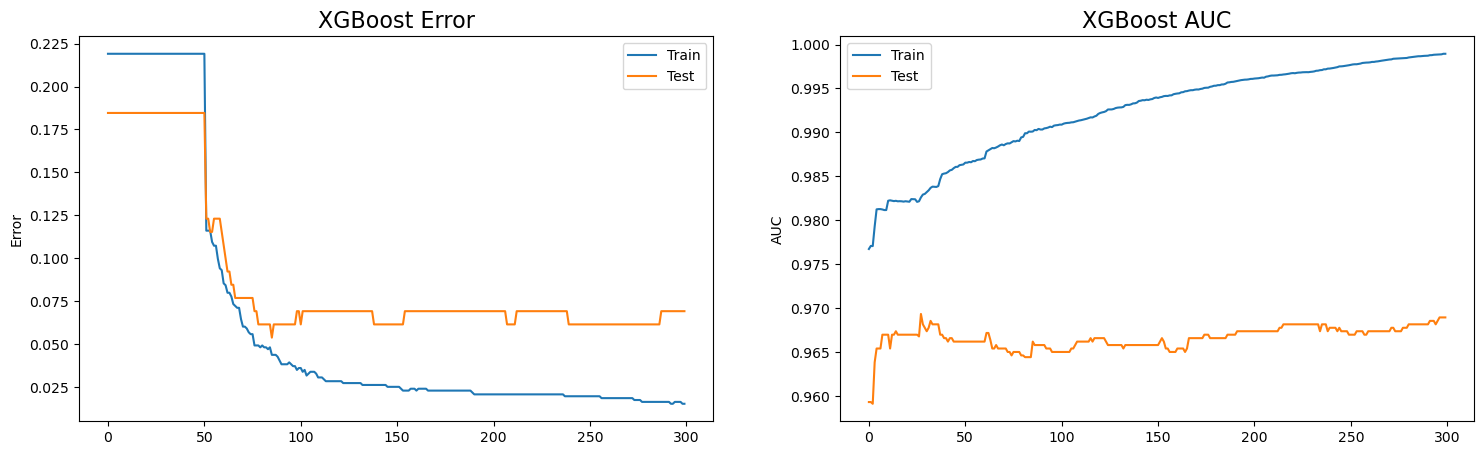

In [23]:
# retrieve performance metrics
results = xgb.evals_result()
epochs = len(results['validation_0']['auc'])
x_axis = range(0, epochs)

# plot log loss and classification error 
fig, axs = plt.subplots(ncols=2, figsize=(18, 5))

# plot log loss
axs[0].plot(x_axis, results['validation_0']['error'], label='Train')
axs[0].plot(x_axis, results['validation_1']['error'], label='Test')
axs[0].legend()
axs[0].set_ylabel('Error')
axs[0].set_title('XGBoost Error', fontsize=16)

# plot classification error
axs[1].plot(x_axis, results['validation_0']['auc'], label='Train')
axs[1].plot(x_axis, results['validation_1']['auc'], label='Test')
axs[1].legend()
axs[1].set_ylabel('AUC')
axs[1].set_title('XGBoost AUC', fontsize=16)

plt.show()


### Evaluate the fitted model

In [24]:
y_pred_train = xgb.predict(X_train)
y_pred_val = xgb.predict(X_valid)
y_pred_test = grid_search.predict(X_test)

y_train_prob = xgb.predict_proba(X_train)
y_val_prob = xgb.predict_proba(X_valid)
y_test_prob = xgb.predict_proba(X_test)

In [25]:
print(classification_report(y_valid,y_pred_val))

              precision    recall  f1-score   support

           0       0.97      0.94      0.96       106
           1       0.78      0.88      0.82        24

    accuracy                           0.93       130
   macro avg       0.87      0.91      0.89       130
weighted avg       0.94      0.93      0.93       130



In [26]:
print(classification_report(y_test,y_pred_test))

              precision    recall  f1-score   support

           0       0.97      0.96      0.96       209
           1       0.84      0.87      0.85        53

    accuracy                           0.94       262
   macro avg       0.90      0.91      0.91       262
weighted avg       0.94      0.94      0.94       262



In [27]:
print(classification_report(y_train,y_pred_train))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99       713
           1       0.94      0.99      0.97       200

    accuracy                           0.98       913
   macro avg       0.97      0.99      0.98       913
weighted avg       0.99      0.98      0.98       913



In [28]:
# Measure F1 score for training, validation and testing
print('Train Accuracy: %0.3f' % accuracy_score(y_train,y_pred_train))
print('Validation Accuracy: %0.3f' % accuracy_score(y_val,y_pred_val))
print('Test Accuracy: %0.3f' % accuracy_score(y_test,y_pred_test))

Train Accuracy: 0.985
Validation Accuracy: 0.931
Test Accuracy: 0.939


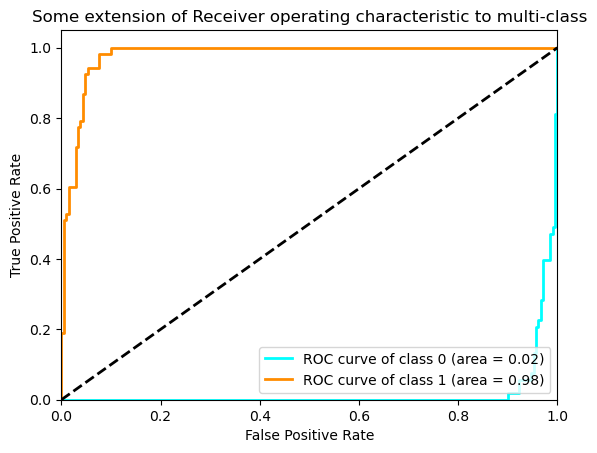

In [29]:
# Plot all ROC curves


#Calculate ROC curve and ROC each class
fpr = dict()
tpr = dict()
roc_auc = dict()
y_bin = label_binarize(y_test, classes=[0,1])
n_classes =2

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test, y_test_prob[:,i])
    roc_auc[i] = roc_auc_score(y_test, y_test_prob[:,i])
plt.figure()
lw=2
colors = cycle(['aqua', 'darkorange']) #, 'cornflowerblue' ]) #'deeppink','navy'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(le.classes_[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

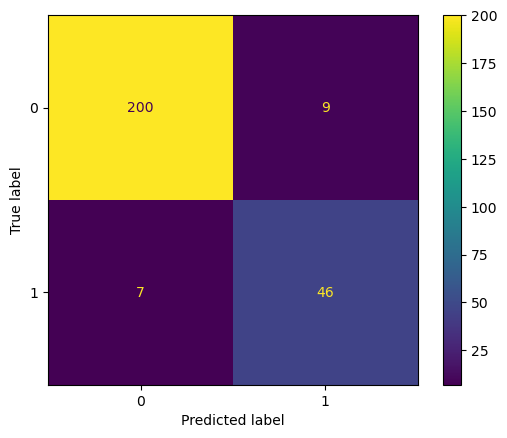

In [30]:
# plot confusion matrix for test set
cm = confusion_matrix(y_test, y_pred_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot();

In [31]:
explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(X_train)

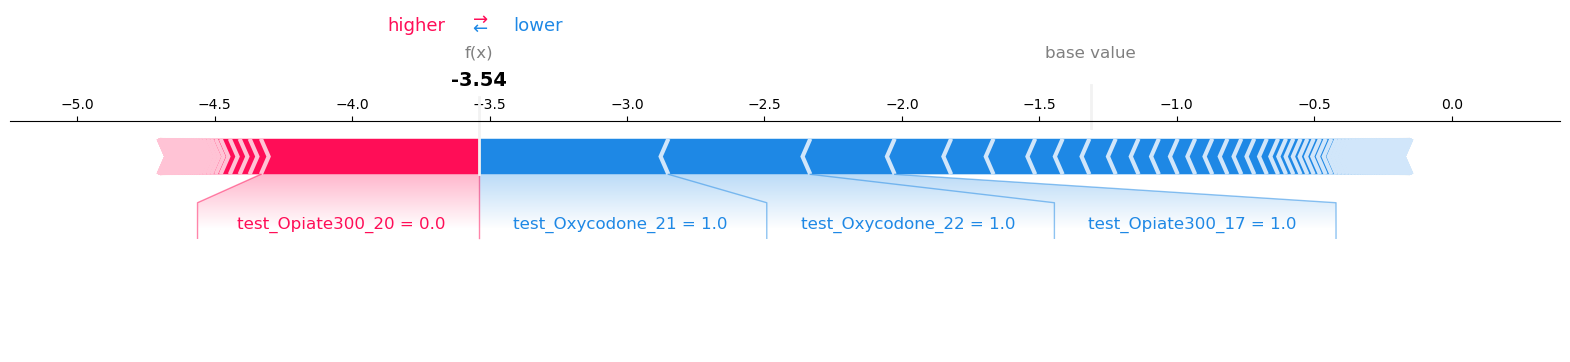

In [32]:
shap.force_plot(explainer.expected_value, shap_values[0, :], X_train.iloc[0, :], matplotlib=True)

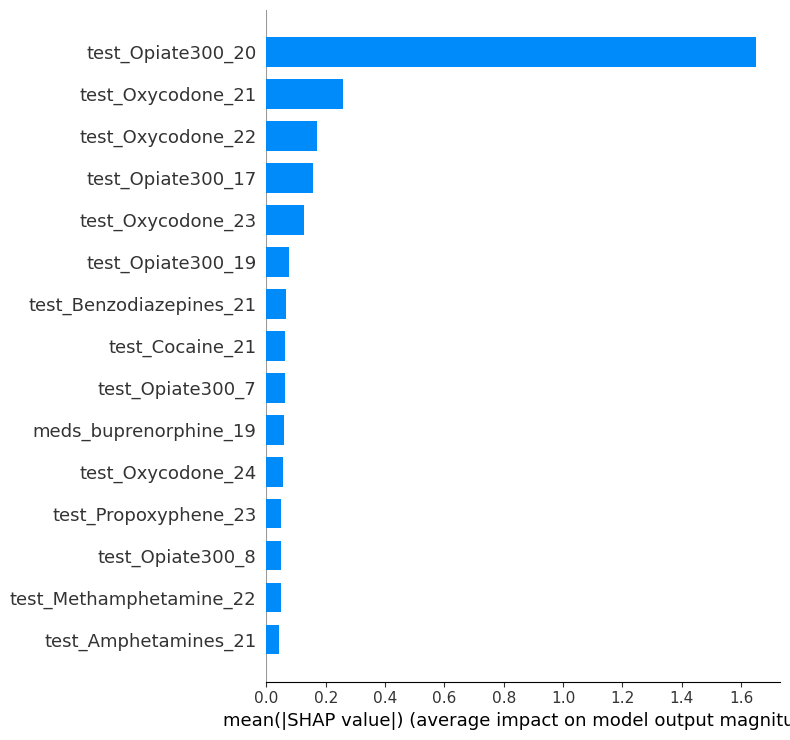

In [36]:
shap.summary_plot(shap_values, X_train, plot_type="bar", max_display=15)

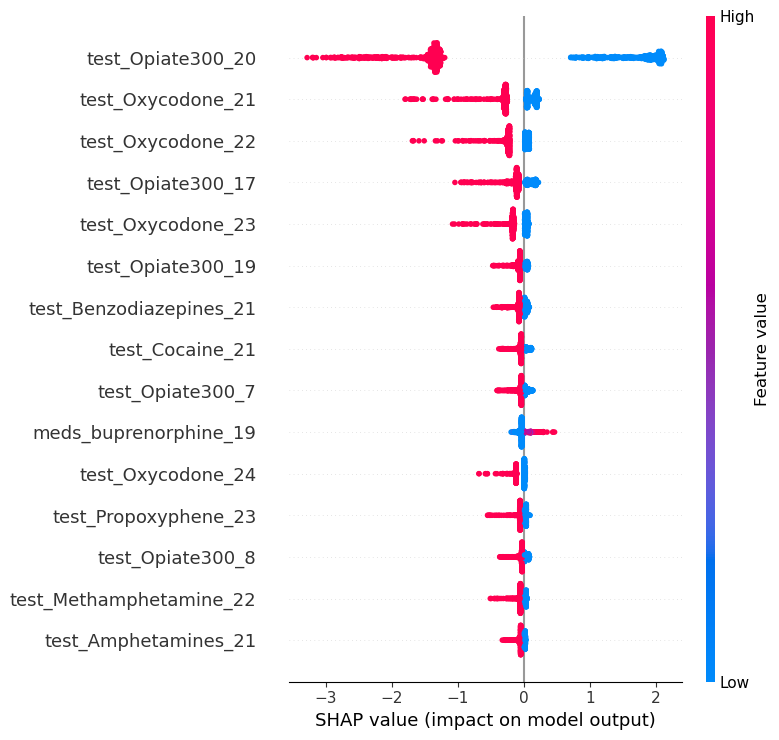

In [35]:
shap.summary_plot(shap_values, X_train, max_display=15)